___
# Toy GARCH(1,1): The Impact of Parameter Variability on VaR and Forecast Skill
*GARCH(1,1), Manual Optimization, Monte Carlo Simulation, VaR, Forecast Accuracy, Parameter Variability*
___
The purpose of this notebook is to ensure I have a good grasp of the underlying machinery before I attempt a DCC implementation from scratch. I still want to make something interesting of this project so this isn't entirely an exercise of pure imitation. 

I initially aimed to examine how distributional assumptions affect GARCH model parameters, but after reviewing some research suggesting minimal impact of distributional choices on univariate GARCH estimation, I pivoted to a question that is equally as relevant, I hope: how much can GARCH parameters naturally vary, and what are the practical implications? I know ARIMA has some theoretical leeway, and I've seen it both in my experience and from my reading. I'd guess GARCH has a similar kind of looseness in certain places in certain contexts. Guess I'll find out.

Using Monte Carlo simulations, I investigate the relationship between parameter accuracy, forecast skill, and Value-at-Risk (VaR) estimation in GARCH(1,1) models. By specifying the data generating process as a GARCH(1,1) and re-estimating parameters, I can quantify both estimation variability and its effects on model performance.

The analysis focuses on three key questions:
- How much do estimated GARCH parameters typically vary from their true values?
- Does parameter accuracy affect volatility forecasting performance?
- How does parameter variability affect risk metrics like VaR?

The log-likelihood and optimisation are implemented manually for flexibility in case I wish to try other distributions later, and for full comprehension of the propagated impacts downstream of the modified assumptions. 

Since this is an exercise in understanding, I will be implementing the maths directly as I read and translate it from:

[Orskaug, E. (2009). Multivariate DCC-GARCH Model - With Various Error Distributions](http://hdl.handle.net/11250/259296)

In [1]:
from implement_garch_fns import *

Given the goal of this analysis, I'm going to hard-code all the parameters for my generated data, then try to retreive the parameters with my implementation. The $p=q=1$ assumtion will also underlie everything else herein.

In [2]:
seed = 42
n = 1000

r, a, h, z = generate_garch_data(n, alpha0=0.01, alpha1=0.05, beta1=0.9, mu=0.001)

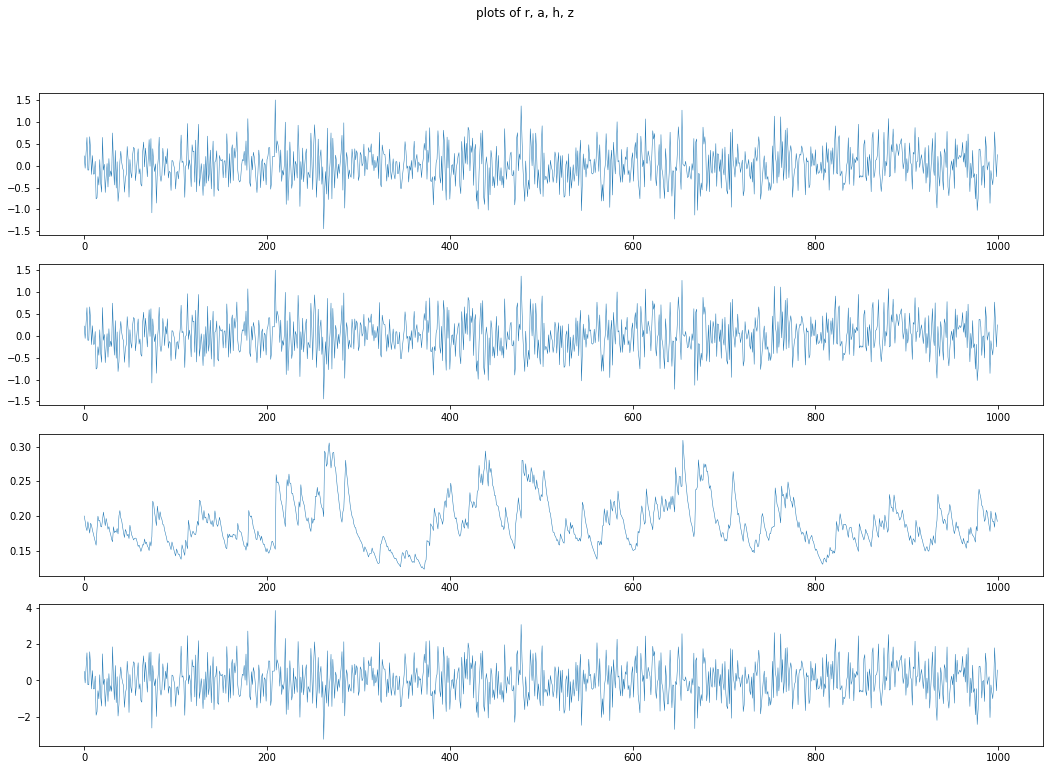

In [3]:
_, axes = plt.subplots(4,1, figsize=(18, 12))

for ax, data in list(zip(axes, [r, a, h, z])):
    ax.plot(range(n), data, lw=0.5)
    _.suptitle("plots of r, a, h, z")

### Recover the parameters
Recovering the params requires finding a set that maximises the log-likelihood function. So, I'll need to translate the log-likelihood from the refrence into a py function to be optimised - the paper uses quasi newton Broyden-Fletcher-Goldfarb-Shanno.

The log function is: 

$$
ln(L) = l(a_{m+1}, ..., a_n | \alpha, \beta, a_1, ..., a_m)
$$

So for our p = q = 1 case:

$$
\begin{align}
ln(L) &= l(a_2, ..., a_n | \alpha, \beta, a_1)\\
&=-\frac{1}{2} \sum_{t=2}^T [ln(h_t) + \frac{a^2_t}{h_t}] + const
\end{align}
$$

and $h_t = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 h_{t-1}$

const can be dropped since it doesn't affect optimisation

I need to:
- Make an appropriate choice of $h_1$
- Pick an optimiser
- Design my function to satisfy the form required by the chosen optimiser

### Choice of $h_1$

The long run variance of a GARCH(1,1) can be calculated so long as the $a_t$ is a stationary process. If it is stationary, then the long run variance is: 

$$
\sigma^2 = \frac{\alpha_0}{1-(\alpha_1 + \beta_1)}
$$


### Choice of optimiser
Start with BFGS since it's simple and available in Scipy

Update: I couldn't initially get BFGS to work. I eventually did get a working version using Nedler-mead which is a derivative-free optimisation method. I have a feeling that the problem is how close $\alpha_1 + \beta_1$ is to 1 or there are places where $h$ is close to zero?. Whatever the case, Orskaug repeatedly mentions related issues around gradient methods. The paper suggests to sweep through a few initial points to find global optimum.

Using L-BFGS-B with tight bounds around whatever the Nedler-mead method finds does actually converge. I used a parameter sweep to find that using the initial params as anything around the true values is ideal - obviously. There's no reason to add convoluted noise to this project, so i'm going to provide NM with initial parameters equal to the true parameters.

In [4]:
# --- Run Nedler Mead optimisation method 

initial_params = [0.01, 0.05, 0.9]
nm_result = minimize(lambda params: -log_likelihood(params, a), 
                  initial_params, 
                  method='Nelder-Mead', 
                  options={'maxiter': 10000, 'disp': True})
print(nm_result)

Optimization terminated successfully.
         Current function value: -358.828811
         Iterations: 67
         Function evaluations: 122
 final_simplex: (array([[0.01069524, 0.02877618, 0.91196579],
       [0.01070629, 0.02878374, 0.91189379],
       [0.01070268, 0.028782  , 0.911926  ],
       [0.01068935, 0.02873995, 0.91203575]]), array([-358.82881071, -358.82881029, -358.82881005, -358.82880913]))
           fun: -358.82881070954534
       message: 'Optimization terminated successfully.'
          nfev: 122
           nit: 67
        status: 0
       success: True
             x: array([0.01069524, 0.02877618, 0.91196579])


In [5]:
# --- Run bounded BFGS optimisation method - just to see that it works

bnds = ((0.005, 0.02), (0.03, 0.06), (0.85, 0.93))
bfgs_result = minimize(log_likelihood, initial_params, args=a ,method='L-BFGS-B', bounds=bnds)
print(bfgs_result)

      fun: 197.02181068745557
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9997.19725999, -2722.88946189, -5384.89992005])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.02, 0.06, 0.93])


In [6]:
from arch import arch_model

model = arch_model(a, vol='Garch', p=1, q=1, dist='normal')
arch_results = model.fit(disp='off')

print("arch library params:\n", arch_results.params)

arch library params:
 mu          0.008725
omega       0.010554
alpha[1]    0.028960
beta[1]     0.912798
Name: params, dtype: float64


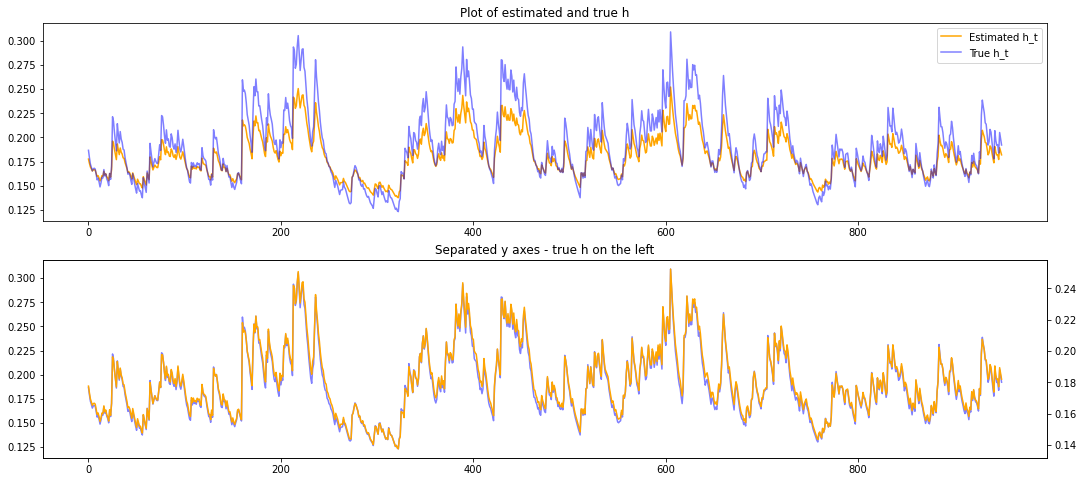

In [7]:
# --- Generate h_t based on estimated parameters

chosen_params = nm_result.x
simulated_h = generate_h_with_params(chosen_params, a)

fig = plot_generated_h(simulated_h, h)

## Comparing estimated to real parameters

In the paper, the starting lines of 5.2.1 suggest that there's not much material difference to changing the distribution assumptions for the univariate case. Chasing the references briefly, it seems this is a well understood phenomenon for cases when $\alpha_1 + \beta_1$ is similar. Obviously that's a practically valuable insight for workflows involving univariate GARCH, but it doesn't make for interesting toy-project results. A more interesting and experientially valuable exercise would be to investigate how different the real and estimated parameters can be, and how much it impacts the fit of the model, estimation, value at risk, similar. If the above BFGS result is considered a decent fit, then the leniency of this difference is somewhat bigger than I would have expected. From a pragmatic lens, one would want some level of confidence in the signals produced by utilising this model.

- **Persistence and Parameter variability**

To start, let's see just how much the parameters actually vary. Given the role of persistence (next point below), I would guess stability is in the sum $\alpha_1 + \beta_1$, which should be picked up as negative correlations between the parameters and their closeness to the true value.

- **MAE and RMSE**

Standard. Good to know but obviously has its limitations which are made obvious in the above plot.

- **Volatility and autocorrelation**

Structurally, the model should rhyme with the real thing. Use ACF of $h^2$ - If the signature of autocorrelation is the same, that's a pretty good signal that the clustering is similar, so a Ljung Box test to check for independence. We can also look at persistence: decay tradeoff of shocks with the half-life.

- **Distribution of standardised residuals**

Since GARCH assumes the standardized residuals are iid, checking the distribution of residuals makes for a simple measure via Kolmogorov-Smirnov. I have a feeling this by itself won't be very enligthening, but we'll see i guess.

- **Tail and kurtosis behaviour**

Equation 14 of the paper shows that $\alpha_1$ is significant to the kurtosis of a GARCH model under iid assumptions. Curiously, the kurtosis for a student t distribution is shown in equation 15 to be quite different from iid assumptions. It's a bit surprising that the parameters wouldn't change much. In any case, tracking the kurtosis might reveal something too.

- **k-step forcasts**

Its one ultimate use case for models, so test forecasting.

- **VaR**

Since volatility modelling is used for risk management, I'll implemenet a VaR along side forecasting as a final measure of model quality. Since VaR calculation utilises the distribution assumptions, the specific distribution still matters here, even if it doesn't impact GARCH parameter estimation 


practical note: I'm using the packaged arch going forward

In [8]:
N = 100
n = 1000

TRUE_ALPHA0 = 0.01
TRUE_ALPHA1 = 0.05
TRUE_BETA1 = 0.9

# Initialize results dataframe
results = pd.DataFrame(columns=[
    'seed', 
    'alpha0', 'alpha1', 'beta1',  # Estimated parameters
    'persistence',                 # α₁ + β₁
    'half_life',                   # log(0.5)/log(α₁+β₁)
    'mae_h', 'rmse_h',             # Error metrics for volatility
    'residual_mean', 'residual_var', 'residual_skew', 'residual_kurt',  # Standardized residuals stats
    'ljung_box_pval',              # Test for autocorrelation in residuals
    'ks_pval',                     # Test for normality of residuals
    'forecasting_rmse',            # k-step forecast accuracy
    'var_95_accuracy'              # Value at Risk accuracy
])

produce_results_df(results, n, N, TRUE_ALPHA0, TRUE_ALPHA1, TRUE_BETA1)

display(results.head())
display(results.mean())

Optimization terminated successfully.
         Current function value: -337.175172
         Iterations: 59
         Function evaluations: 111
Optimization terminated successfully.
         Current function value: -353.586516
         Iterations: 71
         Function evaluations: 135
Optimization terminated successfully.
         Current function value: -305.759027
         Iterations: 53
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: -300.937416
         Iterations: 58
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: -404.729907
         Iterations: 101
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: -330.787744
         Iterations: 54
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: -385.280330
         Iterations: 62
         Function evaluations: 110
Optimi

Optimization terminated successfully.
         Current function value: -317.427710
         Iterations: 55
         Function evaluations: 99
Optimization terminated successfully.
         Current function value: -282.538940
         Iterations: 67
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: -285.384301
         Iterations: 63
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: -335.852220
         Iterations: 71
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -356.560061
         Iterations: 78
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: -299.424590
         Iterations: 58
         Function evaluations: 105
Optimization terminated successfully.
         Current function value: -323.965735
         Iterations: 66
         Function evaluations: 118
Optimiz

,seed,alpha0,alpha1,beta1,persistence,half_life,mae_h,rmse_h,residual_mean,residual_var,residual_skew,residual_kurt,ljung_box_pval,ks_pval,forecasting_rmse,var_95_accuracy,alpha0_diff,alpha1_diff,beta1_diff,persistence_diff
0,0.0,0.010214,0.043074,0.903105,0.946179,12.528945,0.005448,0.007150,-0.045094,0.997676,0.037605,-0.051586,0.136369,0.116526,0.001501,0.049,0.000214,-0.006926,0.003105,-0.003821
1,1.0,0.032083,0.072893,0.752776,0.825669,3.618414,0.014265,0.019163,0.040972,0.999911,-0.061170,0.209183,0.826233,0.293858,0.031251,0.059,0.022083,0.022893,-0.147224,-0.124331
2,2.0,0.013385,0.041382,0.892534,0.933916,10.138398,0.006958,0.008778,-0.046669,0.994279,0.192008,0.243186,0.787900,0.152564,0.035140,0.053,0.003385,-0.008618,-0.007466,-0.016084
3,3.0,0.008408,0.034632,0.923846,0.958478,16.344373,0.006981,0.008935,0.016873,1.003688,-0.015773,-0.075809,0.610960,0.612646,0.028607,0.040,-0.001592,-0.015368,0.023846,0.008478
4,4.0,0.013097,0.066117,0.855966,0.922083,8.544690,0.016407,0.017764,0.054139,0.997027,0.045693,-0.094469,0.090462,0.216336,0.019508,0.058,0.003097,0.016117,-0.044034,-0.027917


seed                49.500000
alpha0               0.017597
alpha1               0.054483
beta1                0.855639
persistence          0.910122
half_life           12.256072
mae_h                0.012706
rmse_h               0.016524
residual_mean        0.001403
residual_var         0.998879
residual_skew        0.016329
residual_kurt       -0.009482
ljung_box_pval       0.563720
ks_pval              0.577374
forecasting_rmse     0.024933
var_95_accuracy      0.049570
alpha0_diff          0.007597
alpha1_diff          0.004483
beta1_diff          -0.044361
persistence_diff    -0.039878
dtype: float64

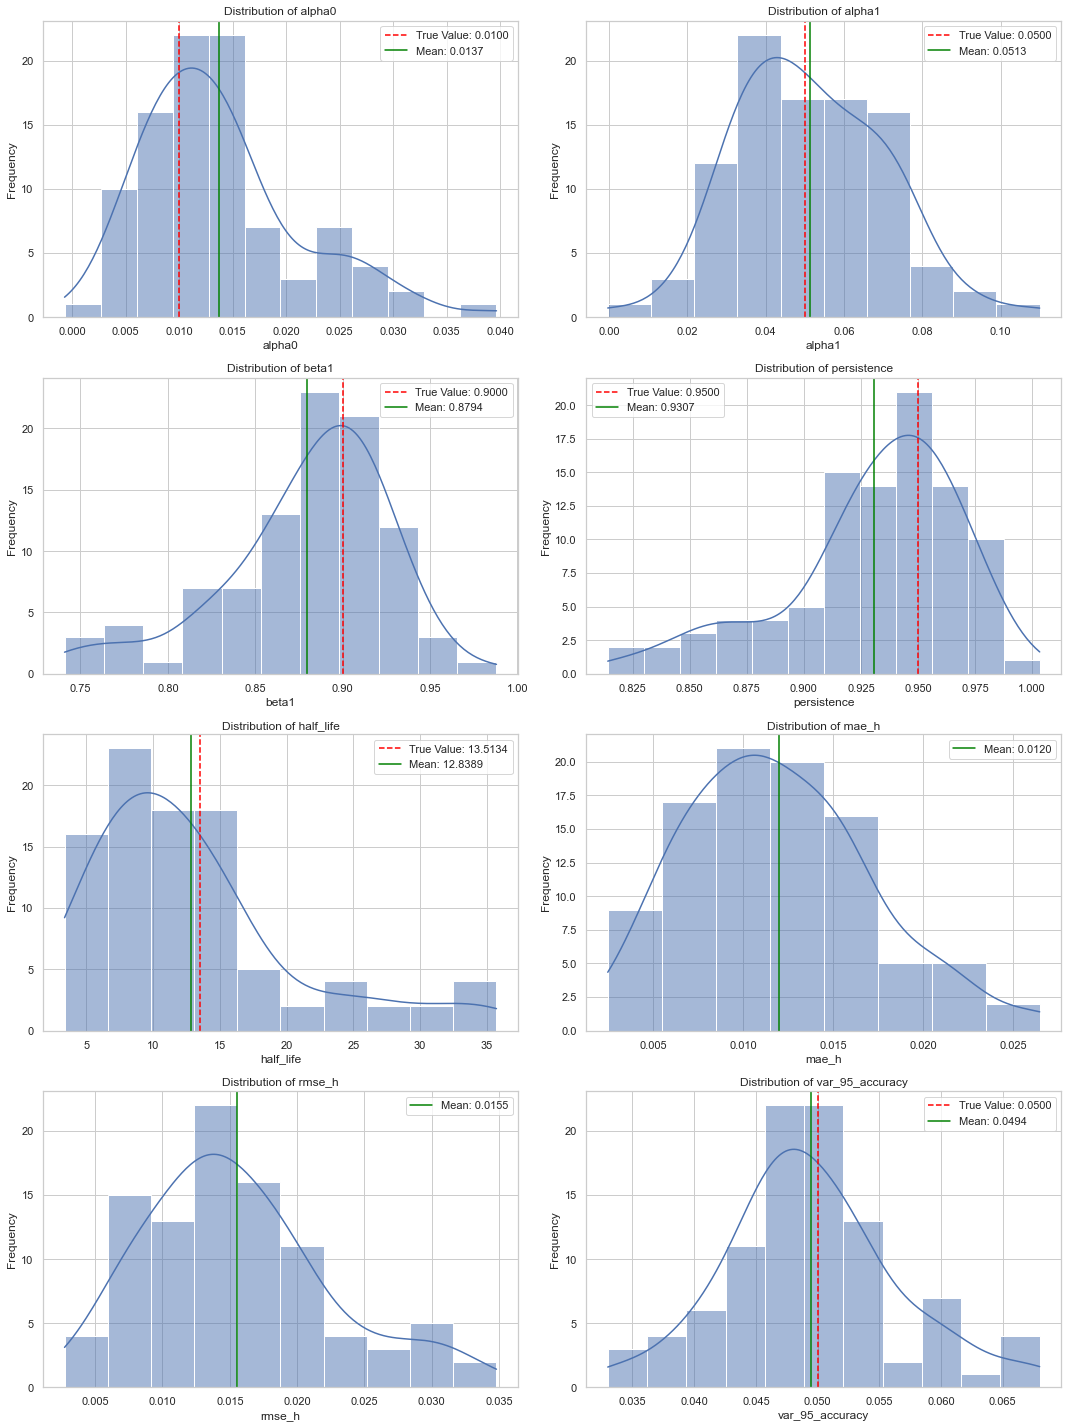

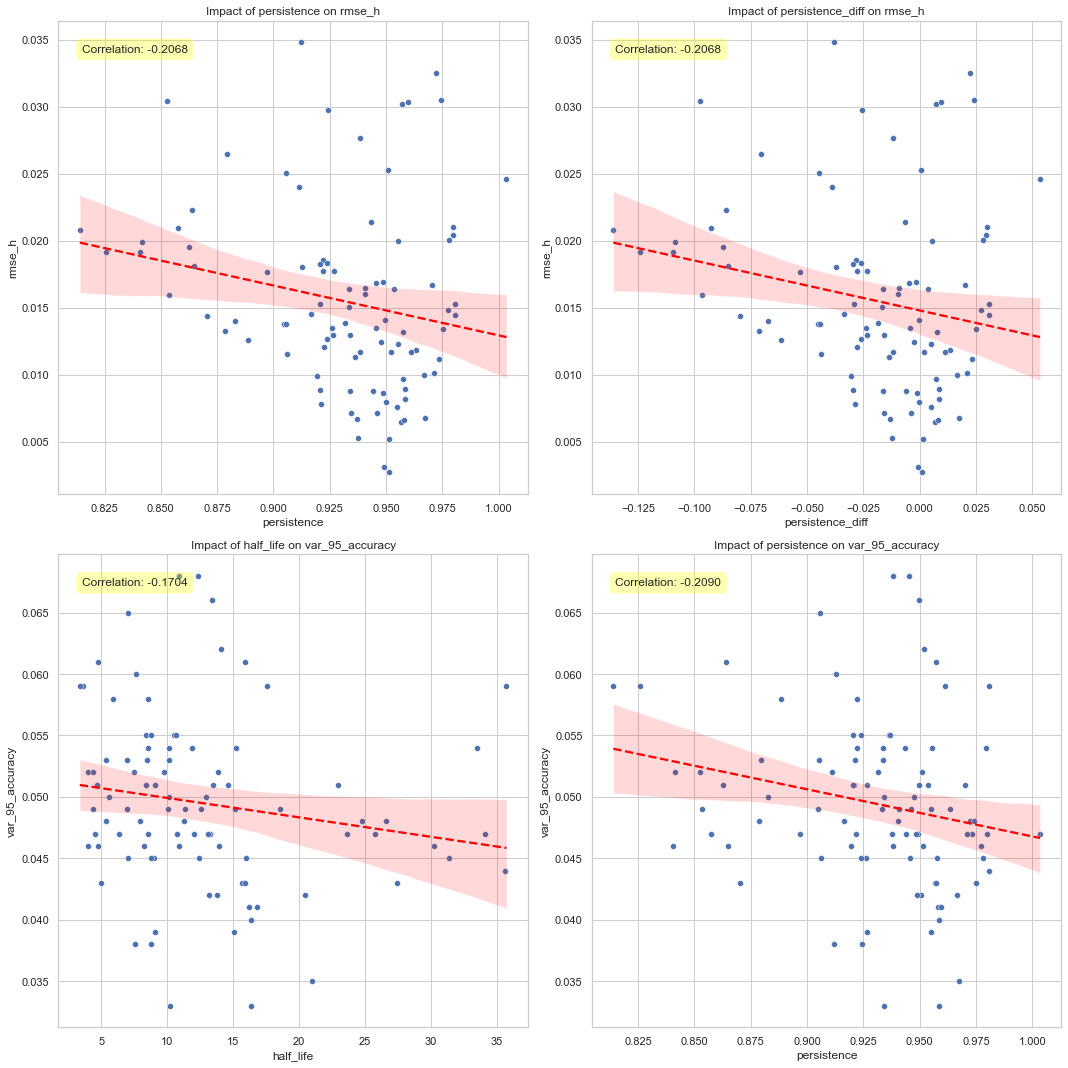

In [9]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_parameter_distributions(results, true_params=[0.01, 0.05, 0.9]):
    """Plot distributions of all key metrics with reference lines for true values"""
    
    # Define columns to plot and their true values/references
    plot_cols = {
        'alpha0': true_params[0],
        'alpha1': true_params[1],
        'beta1': true_params[2],
        'persistence': true_params[1] + true_params[2],
        'half_life': np.log(0.5) / np.log(true_params[1] + true_params[2]),
        'mae_h': None,
        'rmse_h': None,
        'var_95_accuracy': 0.05  # Perfect accuracy would be 0.05 (5% violations)
    }
    
    # Create a grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    # Plot each distribution
    for i, (col, true_val) in enumerate(plot_cols.items()):
        sns.histplot(results[col], kde=True, ax=axes[i])
        
        # Add reference line for true value if applicable
        if true_val is not None:
            axes[i].axvline(true_val, color='red', linestyle='--', 
                          label=f'True Value: {true_val:.4f}')
            axes[i].legend()
        
        # Add mean line
        mean_val = results[col].mean()
        axes[i].axvline(mean_val, color='green', linestyle='-', 
                      label=f'Mean: {mean_val:.4f}')
        
        # Format plot
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
    
    plt.tight_layout()
    return fig

def plot_parameter_correlations(results):
    """Plot key parameter correlations"""
    
    # Define the column pairs to plot
    corr_pairs = [
        ('alpha0_diff', 'alpha1_diff'),
        ('alpha1_diff', 'beta1_diff'),
        ('persistence_diff', 'rmse_h'),
        ('persistence', 'half_life'),
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, (x, y) in enumerate(corr_pairs):
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=results, ax=axes[i])
        # Add regression line
        sns.regplot(x=x, y=y, data=results, scatter=False, 
                   ax=axes[i], color='red', line_kws={"linestyle":"--"})
        
        # Calculate correlation
        corr = results[x].corr(results[y])
        
        # Add correlation text
        axes[i].annotate(f'Correlation: {corr:.4f}', 
                        xy=(0.05, 0.95), xycoords='axes fraction',
                        ha='left', va='top',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        # Format plot
        axes[i].set_title(f'Relationship between {x} and {y}')
    
    plt.tight_layout()
    return fig

def plot_performance_relationships(results):
    """Plot relationships between parameters and performance metrics"""
    
    # Define the column pairs to plot (x, y)
    perf_pairs = [
        ('persistence', 'rmse_h'),
        ('persistence_diff', 'rmse_h'),
        ('half_life', 'var_95_accuracy'),
        ('persistence', 'var_95_accuracy')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, (x, y) in enumerate(perf_pairs):
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=results, ax=axes[i])
        
        # Add regression line
        sns.regplot(x=x, y=y, data=results, scatter=False, 
                   ax=axes[i], color='red', line_kws={"linestyle":"--"})
        
        # Calculate correlation
        corr = results[x].corr(results[y])
        
        # Add correlation text
        axes[i].annotate(f'Correlation: {corr:.4f}', 
                        xy=(0.05, 0.95), xycoords='axes fraction',
                        ha='left', va='top',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
        
        # Format plot
        axes[i].set_title(f'Impact of {x} on {y}')
    
    plt.tight_layout()
    return fig


filtered_results = results[results['beta1_diff'] > -0.25].copy()

fig1 = plot_parameter_distributions(filtered_results)
# fig2 = plot_parameter_correlations(results)
fig3 = plot_performance_relationships(filtered_results)
plt.show()

/var/folders/sm/_zch1p6n05q67_3dyldhm3l40000gn/T/ipykernel_16188/2313348351.py:118: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(scatter)


,seed,alpha0,alpha1,beta1,persistence,half_life,mae_h,rmse_h,residual_mean,residual_var,...,residual_kurt,ljung_box_pval,ks_pval,forecasting_rmse,var_95_accuracy,alpha0_diff,alpha1_diff,beta1_diff,persistence_diff,case_type
21,21.0,0.025203,0.060438,0.809920,0.870358,4.992042,0.010741,0.014351,-0.043184,0.997356,...,0.107215,0.603260,0.322031,0.012697,0.043,0.015203,0.010438,-0.090080,-0.079642,Typical
24,24.0,0.017674,-0.000270,0.912361,0.912091,7.532943,0.026462,0.034811,0.014372,1.004784,...,-0.062934,0.312923,0.270906,0.026851,0.038,0.007674,-0.050270,0.012361,-0.037909,Worst
11,11.0,0.010026,0.048608,0.902527,0.951135,13.835529,0.002629,0.002726,-0.007073,1.002122,...,-0.115220,0.446324,0.928547,0.023508,0.052,0.000026,-0.001392,0.002527,0.001135,Best
60,60.0,0.031917,0.109948,0.742598,0.852546,4.344976,0.021692,0.030438,0.009146,0.999270,...,-0.132420,0.702728,0.931915,0.035339,0.052,0.021917,0.059948,-0.157402,-0.097454,Surprising


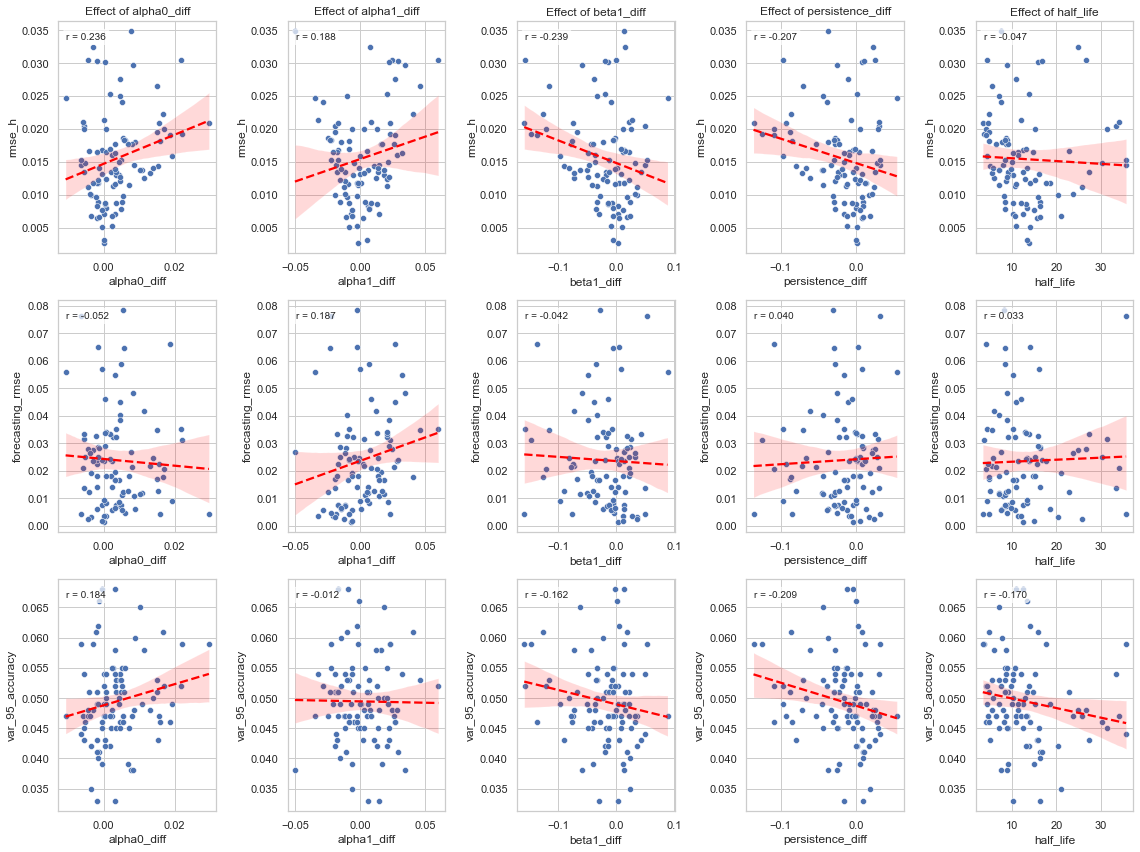

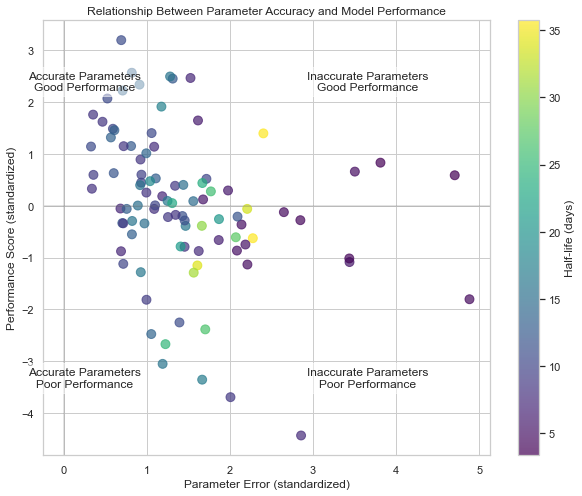

In [11]:
def create_heatmap_correlation(results):
    """Create a correlation heatmap of important metrics"""
    
    # Select relevant columns for correlation analysis
    cols_to_include = [
        'alpha0', 'alpha1', 'beta1', 'persistence', 'half_life',
        'mae_h', 'rmse_h', 'residual_var', 'residual_kurt',
        'ljung_box_pval', 'ks_pval', 'forecasting_rmse', 'var_95_accuracy'
    ]
    
    # Create correlation matrix
    corr_matrix = results[cols_to_include].corr()
    
    # Plot heatmap
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    heatmap = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, annot=True, fmt=".2f", annot_kws={"size": 8})
    
    plt.title('Correlation Matrix of GARCH Model Metrics', fontsize=16)
    plt.tight_layout()
    
    return plt.gcf()

def plot_performance_matrix(results):
    """Create a visual matrix showing the relationship between parameter errors and performance metrics"""
    
    # Define parameter error columns and performance metrics
    param_cols = ['alpha0_diff', 'alpha1_diff', 'beta1_diff', 'persistence_diff', 'half_life']
    perf_cols = ['rmse_h', 'forecasting_rmse', 'var_95_accuracy']
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(perf_cols), len(param_cols), figsize=(16, 12))
    
    # Fill in each subplot
    for i, perf in enumerate(perf_cols):
        for j, param in enumerate(param_cols):
            ax = axes[i, j]
            
            # Create scatter plot
            sns.scatterplot(x=param, y=perf, data=results, ax=ax)
            
            # Add regression line
            sns.regplot(x=param, y=perf, data=results, scatter=False, 
                       ax=ax, color='red', line_kws={"linestyle":"--"})
            
            # Calculate correlation
            corr = results[param].corr(results[perf])
            
            # Add correlation coefficient
            ax.annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                      ha='left', va='top', fontsize=10,
                      bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
            
            # Set title only for top row
            if i == 0:
                ax.set_title(f'Effect of {param}')
            
            # Set y-label only for leftmost column
            if j == 0:
                ax.set_ylabel(perf)
            
    plt.tight_layout()
    return fig

def plot_performance_quadrants(results):
    """Plot quadrant analysis of parameter errors vs performance"""
    
    # Create a standardized version of the data for comparison
    scaler = StandardScaler()
    results_scaled = pd.DataFrame(
        scaler.fit_transform(results[['persistence_diff', 'rmse_h', 'var_95_accuracy']]),
        columns=['persistence_diff', 'rmse_h', 'var_95_accuracy']
    )
    params_scaled = pd.DataFrame(
        scaler.fit_transform(results[['alpha0_diff', 'alpha1_diff', 'beta1_diff']]),
        columns=['alpha0_diff', 'alpha1_diff', 'beta1_diff']
    )
    
    # create compound param error
    param_error = np.sqrt(params_scaled['alpha0_diff']**2 + 
                          params_scaled['alpha1_diff']**2 + 
                          params_scaled['beta1_diff']**2)

    perf_score = -results_scaled['rmse_h'] + results_scaled['var_95_accuracy'] # invert rmse since lower is better
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot points
    scatter = ax.scatter(param_error, perf_score, c=results['half_life'], 
                         cmap='viridis', alpha=0.7, s=80)
    
    # Add dividing lines at 0
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    # Add labels for quadrants
    ax.text(param_error.max() * 0.75, perf_score.max() * 0.75, 
            "Inaccurate Parameters\nGood Performance", 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    ax.text(param_error.max() * 0.75, perf_score.min() * 0.75, 
            "Inaccurate Parameters\nPoor Performance", 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    ax.text(param_error.min() * 0.75, perf_score.max() * 0.75, 
            "Accurate Parameters\nGood Performance", 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    ax.text(param_error.min() * 0.75, perf_score.min() * 0.75, 
            "Accurate Parameters\nPoor Performance", 
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Half-life (days)')
    
    # Add labels and title
    # ax.set_yscale('log')
    ax.set_xlabel('Parameter Error (standardized)')
    ax.set_ylabel('Performance Score (standardized)')
    ax.set_title('Relationship Between Parameter Accuracy and Model Performance')
    
    return fig

def identify_notable_cases(results):
    """Identify and return notable cases for deeper investigation"""
    
    # Find median performance case
    typical_idx = results['rmse_h'].sort_values().index[len(results)//2]
    
    # Find worst performance case
    worst_idx = results['rmse_h'].idxmax()
    
    # Find best performance case
    best_idx = results['rmse_h'].idxmin()
    
    # Find case with biggest parameter error but good performance
    # (standardize first)
    results_std = results.copy()
    for col in ['alpha0_diff', 'alpha1_diff', 'beta1_diff', 'persistence_diff']:
        results_std[col] = abs(results_std[col]) / abs(results_std[col]).max()
    
    # Combine parameter errors
    results_std['param_error'] = (results_std['alpha0_diff'] + 
                                 results_std['alpha1_diff'] + 
                                 results_std['beta1_diff'])
    
    # Standardize performance
    results_std['rmse_std'] = results_std['rmse_h'] / results_std['rmse_h'].max()
    
    # Calculate "surprisingly good" score (high error, low rmse)
    results_std['surprising'] = results_std['param_error'] - results_std['rmse_std']
    surprising_idx = results_std['surprising'].idxmax()
    
    # Create a summary dataframe
    notable_cases = results.loc[[typical_idx, worst_idx, best_idx, surprising_idx]].copy()
    notable_cases['case_type'] = ['Typical', 'Worst', 'Best', 'Surprising']
    
    return notable_cases

filtered_results = results[results['beta1_diff'] > -0.25].copy()

# fig1 = create_heatmap_correlation(results)
notable_cases = identify_notable_cases(filtered_results)
fig2 = plot_performance_matrix(filtered_results)
fig3 = plot_performance_quadrants(filtered_results)
display(notable_cases)

In [12]:
def plot_custom_relationships(results, x_vars, y_vars, figsize=(20, 15)):
    """
    Create a matrix of plots showing relationships between specified variables
    
    Parameters:
    -----------
    results : DataFrame
        The results data
    x_vars : list
        List of column names to use as x variables
    y_vars : list
        List of column names to use as y variables
    figsize : tuple
        Figure size
    """
    
    # Create figure with subplots
    fig, axes = plt.subplots(len(y_vars), len(x_vars), figsize=figsize)
    
    # Handle single row or column case
    if len(y_vars) == 1 and len(x_vars) == 1:
        axes = np.array([[axes]])
    elif len(y_vars) == 1:
        axes = axes.reshape(1, -1)
    elif len(x_vars) == 1:
        axes = axes.reshape(-1, 1)
    
    # Fill in each subplot
    for i, y_var in enumerate(y_vars):
        for j, x_var in enumerate(x_vars):
            ax = axes[i, j]
            
            # Create scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=results, ax=ax, s=80)
            
            # Add regression line
            sns.regplot(x=x_var, y=y_var, data=results, scatter=False, 
                       ax=ax, color='red', line_kws={"linestyle":"--"})
            
            # Calculate correlation
            corr = results[x_var].corr(results[y_var])
            
            # Add correlation coefficient
            ax.annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                      ha='left', va='top', fontsize=12,
                      bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
            
            # Set title only for top row
            if i == 0:
                ax.set_title(f'{x_var}', fontsize=14)
            
            # Set y-label only for leftmost column
            if j == 0:
                ax.set_ylabel(f'{y_var}', fontsize=14)
                
            # Increase tick label size
            ax.tick_params(axis='both', which='major', labelsize=12)
            
    plt.tight_layout()
    return fig
    

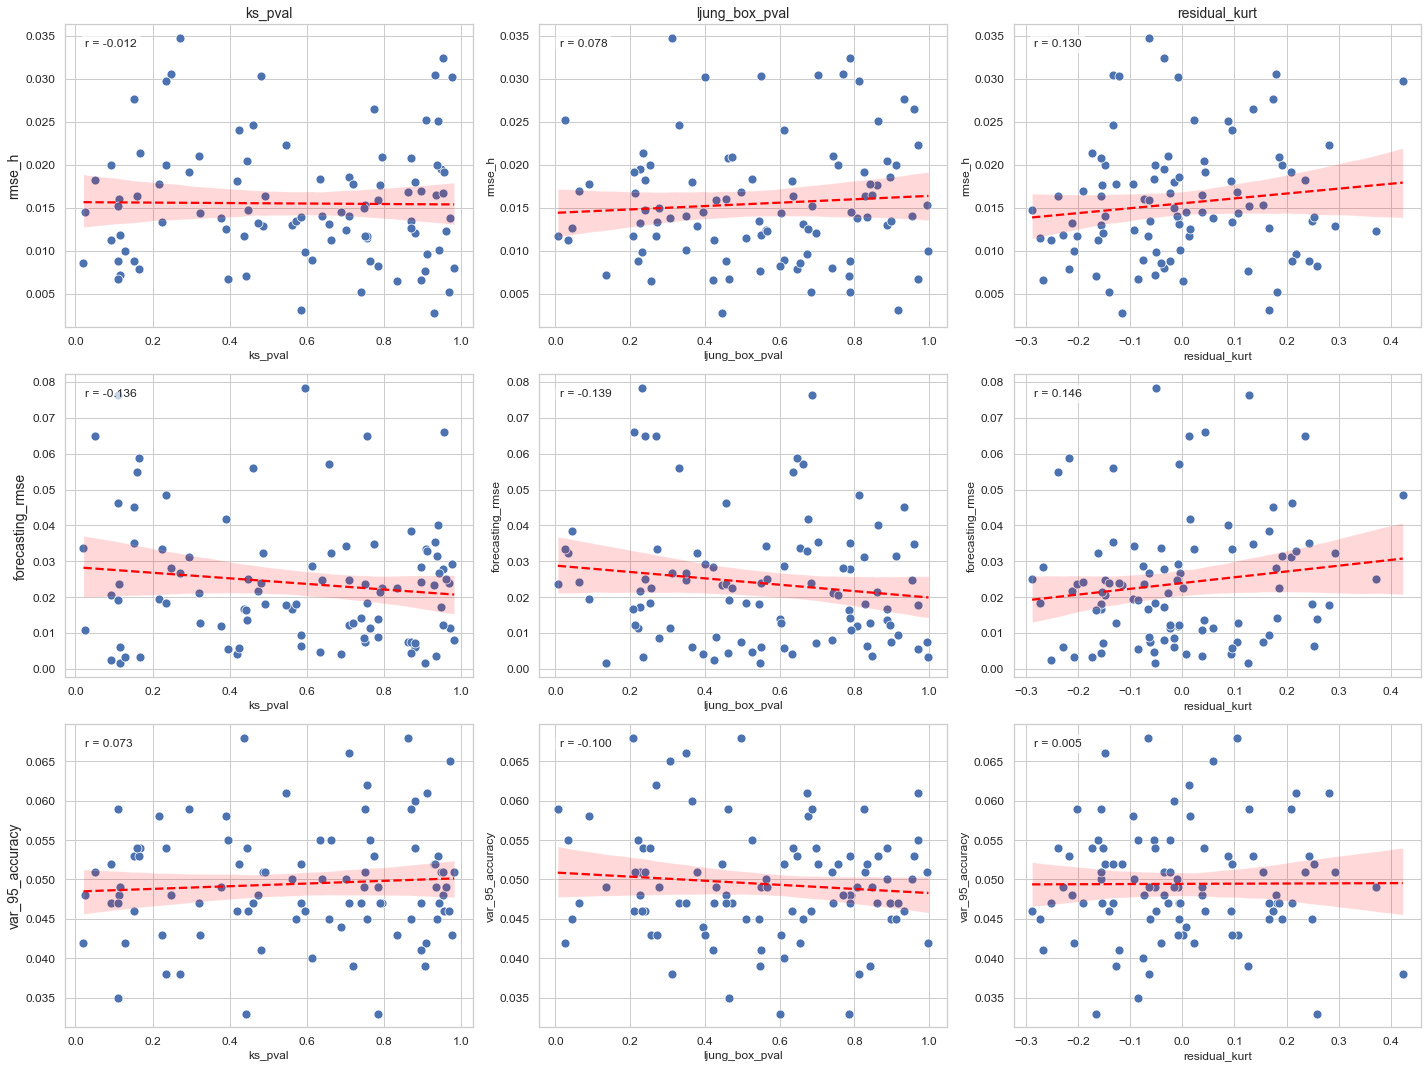

In [13]:
# # 1. Half-life relationship with performance metrics
# fig1 = plot_custom_relationships(
#     filtered_results,
#     x_vars=['half_life'],
#     y_vars=['rmse_h', 'forecasting_rmse', 'var_95_accuracy']
# )

# # 2. Residual diagnostics vs parameter errors
# fig2 = plot_custom_relationships(
#     filtered_results,
#     x_vars=['alpha0_diff', 'alpha1_diff', 'beta1_diff', 'persistence_diff'],
#     y_vars=['residual_var', 'residual_kurt', 'ks_pval']
# )

# # 3. True parameters vs estimation errors
# fig3 = plot_custom_relationships(
#     filtered_results,
#     x_vars=['alpha0', 'alpha1', 'beta1', 'persistence'],
#     y_vars=['alpha0_diff', 'alpha1_diff', 'beta1_diff', 'persistence_diff']
# )

# # 4. Half-life vs parameter errors
# fig4 = plot_custom_relationships(
#     filtered_results,
#     x_vars=['half_life'],
#     y_vars=['alpha0_diff', 'alpha1_diff', 'beta1_diff', 'persistence_diff']
# )

# # 5. Relationship between different performance metrics
# fig5 = plot_custom_relationships(
#     filtered_results,
#     x_vars=['rmse_h', 'forecasting_rmse'],
#     y_vars=['var_95_accuracy']
# )

# --- these two are the key plots for the conclusion below

# 6. Residual diagnostics vs parameter errors - this is where any actual innovatin happens model to model
fig6 = plot_custom_relationships(
    filtered_results,
    x_vars=['ks_pval','ljung_box_pval', 'residual_kurt'],
    y_vars=['rmse_h', 'forecasting_rmse', 'var_95_accuracy']
)

# 7. Residual diagnostics vs parameter errors - this should be pretty empty of anything interesting happenming
# fig7 = plot_custom_relationships(
#     filtered_results,
#     x_vars=['alpha0_diff', 'alpha1_diff', 'beta1_diff',],
#     y_vars=['rmse_h', 'forecasting_rmse', 'var_95_accuracy']
# )

## GARCH Parameter Variability Project: Key Findings

The simulations provide some interesting insights into the relationship between parameter accuracy and model performance in GARCH(1,1) models. Most notably, parameter estimation errors show relationships with volatility estimation accuracy and forecasting performance, but have limited impact on VaR calculations.

When examining the diagnostics results, a curious pattern emerges: residual properties (normality, autocorrelation, kurtosis) show almost no correlation with model performance metrics. This makes sense in our experimental context - since we're generating data from a GARCH(1,1) process and estimating GARCH(1,1) models, we've created a "perfect match" scenario. The residuals are essentially empty of meaningful information because the model specification perfectly matches the data generator.

Parameter differences thus become the key driver of performance variation in our simulations. The persistence parameter (α₁+β₁) demonstrates greater stability than individual parameters, suggesting models can maintain reasonable performance even with some individual parameter estimation error, provided they capture the overall volatility persistence correctly.

The practical implication is this: when the model specification is correct, getting the parameters approximately right matters more than achieving perfect residual diagnostics. However, we should be careful about generalizing too far - in real-world applications where the true DGP is unknown, diagnostic tests likely retain their value for detecting model misspecification.

So then the natural extension to this project would be to model data from a higher-order GARCH(p,q) process with p+q=3, but estimating it with a GARCH(1,1), or add some other kind of DGP / model difference. A deliberate misspecification would let us examine whether diagnostic tests become more informative when structural mismatches exist, providing a more complete picture of model robustness under different conditions.

I gather from this project some suggestion of a hierarchy of importance in GARCH modeling: correct model specification first, parameter accuracy second, and residual properties third. I'd hope this matches the intuition of practitioners... more hopefully my own in the near future.